In [18]:
import numpy as np
from hyppo.ksample import MMD
from sparse_shift import KCD
from scipy.stats import wilcoxon
from sparse_shift.datasets import sample_topological
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Test structure

In [314]:
def test_structure(Xs, parent_graph, reps=1000, n_jobs=None):
    """
    Tests pairwise mechanism equality
    
    Parameters
    ----------
    Xs : list of np.ndarray, each shape (n_e, m)
        List of observations from each environment  
    parent_graph : np.ndarray, shape (m, m)
        Adjacency matrix indicating parents of each variable
    reps : int
        Number of permutations for the permutation test
        
    Returns
    -------
    - np.ndarray, shape (e, e, m)
        pvalues for each pairwise test
    """
    E = len(Xs)
    parent_graph = np.asarray(parent_graph)
    M = parent_graph.shape[0]
    conditional_pvalues = np.ones((M, E, E))
    marginal_pvalues = np.ones((M, E, E))
    
    for e1 in range(E):
        for e2 in range(e1+1, E):
            for m in range(M):
                parents = np.where(parent_graph[m] != 0)[0]
                if len(parents) == 0:
                    stat, pvalue = MMD().test(
                        Xs[e1][:, m], Xs[e2][:, m],
                        reps=reps, workers=n_jobs)
                else:
                    stat, pvalue = KCD(n_jobs=n_jobs).test(
                        np.vstack((Xs[e1][:, parents], Xs[e2][:, parents])),
                        np.concatenate((Xs[e1][:, m], Xs[e2][:, m])),
                        np.asarray([0]*Xs[e1].shape[0] + [1]*Xs[e2].shape[0]),
                        reps=reps,
                    )
                conditional_pvalues[m, e1, e2] = pvalue
                conditional_pvalues[m, e2, e1] = pvalue
                
    return conditional_pvalues


def get_triangle_dags():
    """Gets all graphs on 3 variables"""
    dags = []
    for e1 in [-1, 0, 1]: #x1 - x2
        for e2 in [-1, 0, 1]: # x2 - x3
            for e3 in [-1, 0, 1]: # x3 - x1
                # skip if cyclic
                if np.abs(np.sum([e1, e2, e3])) == 3:
                    continue
                # add edges
                dag = np.asarray([[0,  0, 0], [0, 0, 0], [0, 0 ,0]])
                for i, e in enumerate([e1, e2, e3]):
                    if e == 1: # X -> Y
                        dag[i, (i+1)%3] = 1
                    elif e == -1: # X <- Y
                        dag[(i+1)%3, i] = 1
                dags.append(dag)
    return dags

In [315]:
tri_dags = get_triangle_dags()
print(len(tri_dags)) # verify equals 25

25


## 3 variable SCM

In [326]:
# X1 -> X2, X1->X3, X2->X
true_parents = np.asarray([[0,  0, 0], [1, 0, 0], [1, 1 ,0]])
n = 100

g1_noise = lambda: np.abs(np.random.standard_t(df=100))
g1_equations = [
    lambda X, U: U,
    lambda X, U: X[0] + U,
    lambda X, U: X[0] + X[1] + U,
]
g2_equations = [
    lambda X, U: U,
    lambda X, U: np.sin(2*np.pi*X[0]) + U,
    lambda X, U: X[0] + X[1] + U,
]

Xs = [
    sample_topological(n, g1_equations, g1_noise),
    sample_topological(n, g2_equations, g1_noise),
]

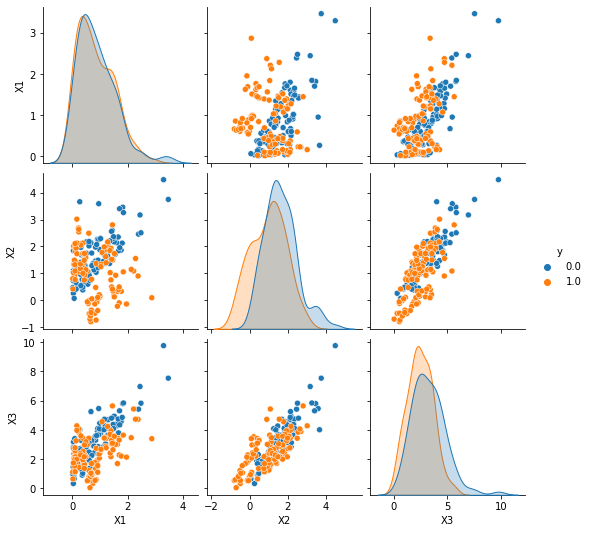

In [327]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1).astype(int)
    )),
    columns=[f'X{i+1}' for i in range(X.shape[1])] + ['y']
)
sns.pairplot(df, hue='y')
plt.show()

In [328]:
pvalues_mat = test_structure(Xs, true_parents, reps=1000, n_jobs=10)

In [329]:
print(pvalues_mat)

[[[1.         1.        ]
  [1.         1.        ]]

 [[1.         0.3036963 ]
  [0.3036963  1.        ]]

 [[1.         0.42057942]
  [0.42057942 1.        ]]]


/Users/rflperry/opt/miniconda3/envs/kcd/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rflperry/opt/miniconda3/envs/kcd/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [204]:
alpha = 0.05
print(np.sum(pvalues_mat <= alpha) // 2)

0


In [233]:
np.sum(tri_dags[0])

2

In [231]:
pval_mats = []
n_changes = []
for dag in tri_dags:
    if np.sum(dag) < 3:
        continue
    print('.', end='')
    pvalues_mat = test_structure(Xs, dag, reps=1000, n_jobs=10)
    pval_mats.append(pvalues_mat)
    n_changes.append(np.sum(pvalues_mat <= alpha) // 2)

.

TypeError: '<=' not supported between instances of 'tuple' and 'float'

In [168]:
n_changes

[1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]

In [171]:
tri_dags[4]

array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [172]:
pval_mats[4]

array([[[1.        , 0.30879956],
        [0.30879956, 1.        ]],

       [[1.        , 0.04995005],
        [0.04995005, 1.        ]],

       [[1.        , 0.01298701],
        [0.01298701, 1.        ]]])

/Users/rflperry/opt/miniconda3/envs/kcd/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rflperry/opt/miniconda3/envs/kcd/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [170]:
np.mean([dag for nc, dag in zip(n_changes, tri_dags) if nc == 0], axis=0)

array([[0.        , 0.41176471, 0.47058824],
       [0.17647059, 0.        , 0.35294118],
       [0.11764706, 0.35294118, 0.        ]])